In [1]:
import sys

sys.path.append("ml-tools-direct-method")

In [11]:
from tools.bandit import generate_bandit_feedback
from tools.estimate import get_estimator_stats, get_value_estimators
from tools.policy import ModelPolicy, UniformPolicy
from tools.utils import datasets, get_bandit, split_data

import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.random import default_rng
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_palette("colorblind")
colors = sns.color_palette()
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

X_MED = 10
Y_MED = 6
XY_MED = (X_MED, Y_MED)

In [3]:
contexts, full_rewards, best_actions = get_bandit(datasets[0])
n, k = full_rewards.shape
_, d = contexts.shape

In [4]:
X_train, y_train, X_test, y_test, full_rewards_test = split_data(
    contexts, full_rewards, best_actions
)

In [5]:
model = LogisticRegression(multi_class="multinomial", max_iter=10000)
model.fit(X_train, y_train)
target_policy = ModelPolicy(model=model, num_actions=k)

In [6]:
target_policy_true_value = target_policy.get_value_estimate(X_test, full_rewards_test)
print(f"Target policy true value {target_policy_true_value}.")

Target policy true value 0.545962678223334.


In [7]:
logging_policy = UniformPolicy(num_actions=k)
print(
    "Logging policy true value {}".format(
        logging_policy.get_value_estimate(X_test, full_rewards_test)
    )
)

Logging policy true value 0.125


In [8]:
trials = 500
val_ests = []
policy = target_policy
policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
rng = default_rng(6)
for i in tqdm(range(trials)):
    contexts, actions, rewards, propensities = generate_bandit_feedback(
        X_test, full_rewards_test, logging_policy, rng=rng
    )
    est = get_value_estimators(
        policy, contexts, actions, rewards, propensities, skip_rf=True
    )
    val_ests.append(est)

df = pd.DataFrame(val_ests)
print(f"Target policy true value {target_policy_true_value}.")
df_stats = get_estimator_stats(df, true_parameter_value=policy_true_value)
print(df_stats)

100%|██████████| 500/500 [00:12<00:00, 40.84it/s]


Target policy true value 0.545962678223334.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.550025  0.123189  0.015176  0.005509  0.004062  0.123256
1     dm  0.496626  0.055070  0.003033  0.002463  0.049336  0.073938
2  dm_iw  0.548998  0.055164  0.003043  0.002467  0.003036  0.055247
3     dr  0.540580  0.055142  0.003041  0.002466  0.005383  0.055405


In [9]:
frames = {}
for data in datasets:

    if data in [
        "satimage",
        "vehicle",
    ]:  # skip these for now, I don't expect them to converge in a linear model.
        continue

    # configure dataset into bandit setting
    print("\n Fetching dataset:", data)
    contexts, full_rewards, best_actions = get_bandit(data)
    n, k = full_rewards.shape
    _, d = contexts.shape
    print(
        f"This dataset has {k} actions, the context space has {d} dimensions, and there are {n} examples."
    )

    # split train test sets
    X_train, y_train, X_test, y_test, full_rewards_test = split_data(
        contexts, full_rewards, best_actions
    )

    # create target policy using logreg
    model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    model.fit(X_train, y_train)
    target_policy = ModelPolicy(model=model, num_actions=k)

    # get true value of target policy -> treated as ground truth for comparing estimates
    target_policy_true_value = target_policy.get_value_estimate(
        X_test, full_rewards_test
    )

    # create logging policy
    logging_policy = UniformPolicy(num_actions=k)

    # run 500 simulations
    trials = 500
    val_ests = []
    policy = target_policy
    policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
    rng = default_rng(6)
    for i in tqdm(range(trials)):
        contexts, actions, rewards, propensities = generate_bandit_feedback(
            X_test, full_rewards_test, logging_policy, rng=rng
        )
        est = get_value_estimators(
            policy, contexts, actions, rewards, propensities, skip_rf=True
        )
        val_ests.append(est)

    df = pd.DataFrame(val_ests)
    print(f"Target policy true value {target_policy_true_value}.")
    df_stats = get_estimator_stats(df, true_parameter_value=policy_true_value)
    df_stats["true"] = policy_true_value
    print(df_stats)

    frames[data] = df_stats


 Fetching dataset: ecoli


  1%|          | 4/500 [00:00<00:13, 36.57it/s]

This dataset has 8 actions, the context space has 7 dimensions, and there are 336 examples.


100%|██████████| 500/500 [00:12<00:00, 41.66it/s]


Target policy true value 0.5385134535251697.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.532302  0.120995  0.014640  0.005411  0.006211  0.121154
1     dm  0.488208  0.060671  0.003681  0.002713  0.050305  0.078813
2  dm_iw  0.543090  0.058571  0.003431  0.002619  0.004577  0.058749
3     dr  0.532120  0.059728  0.003567  0.002671  0.006394  0.060069

 Fetching dataset: glass
This dataset has 6 actions, the context space has 9 dimensions, and there are 214 examples.


100%|██████████| 500/500 [00:10<00:00, 47.28it/s]


Target policy true value 0.45537295454518006.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.459312  0.114198  0.013041  0.005107  0.003939  0.114266
1     dm  0.411123  0.093509  0.008744  0.004182  0.044250  0.103451
2  dm_iw  0.447014  0.108044  0.011674  0.004832  0.008359  0.108367
3     dr  0.438242  0.096366  0.009286  0.004310  0.017131  0.097877

 Fetching dataset: letter-recognition
This dataset has 26 actions, the context space has 16 dimensions, and there are 20000 examples.


100%|██████████| 500/500 [04:11<00:00,  1.99it/s]


Target policy true value 0.6429715761877374.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.642240  0.035169  0.001237  0.001573  0.000731  0.035177
1     dm  0.216279  0.009077  0.000082  0.000406  0.426692  0.426789
2  dm_iw  0.625696  0.016627  0.000276  0.000744  0.017275  0.023977
3     dr  0.624564  0.025262  0.000638  0.001130  0.018408  0.031257

 Fetching dataset: optdigits
This dataset has 10 actions, the context space has 64 dimensions, and there are 5620 examples.


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


Target policy true value 0.9562897685329459.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.958504  0.056172  0.003155  0.002512  0.002215  0.056216
1     dm  0.692992  0.014735  0.000217  0.000659  0.263298  0.263710
2  dm_iw  0.919441  0.021369  0.000457  0.000956  0.036848  0.042596
3     dr  0.910416  0.019491  0.000380  0.000872  0.045874  0.049843

 Fetching dataset: pendigits
This dataset has 10 actions, the context space has 16 dimensions, and there are 10992 examples.


/Users/danturkel/.pyenv/versions/3.6.12/envs/ml-tools/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|██████████| 500/500 [02:44<00:00,  3.03it/s]


Target policy true value 0.9269894041666168.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.926477  0.040182  0.001615  0.001797  0.000512  0.040186
1     dm  0.551694  0.011981  0.000144  0.000536  0.375295  0.375486
2  dm_iw  0.928702  0.008064  0.000065  0.000361  0.001713  0.008244
3     dr  0.916582  0.018314  0.000335  0.000819  0.010407  0.021065

 Fetching dataset: yeast


  0%|          | 0/500 [00:00<?, ?it/s]

This dataset has 10 actions, the context space has 8 dimensions, and there are 1484 examples.


100%|██████████| 500/500 [00:25<00:00, 19.36it/s]

Target policy true value 0.3288661917016415.
    stat      mean        SD       var        SE      bias      RMSE
0     iw  0.329497  0.039352  0.001549  0.001760  0.000631  0.039357
1     dm  0.295861  0.030642  0.000939  0.001370  0.033005  0.045037
2  dm_iw  0.332024  0.030074  0.000904  0.001345  0.003157  0.030239
3     dr  0.329535  0.030502  0.000930  0.001364  0.000669  0.030509


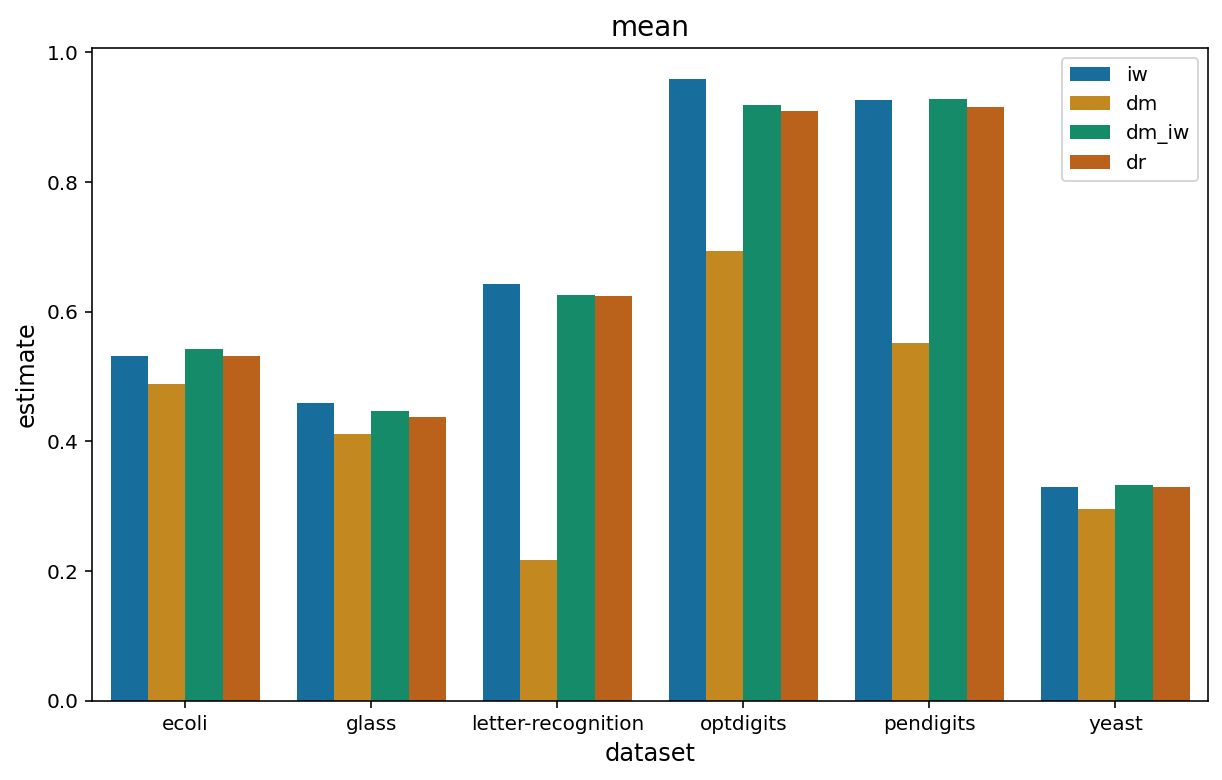

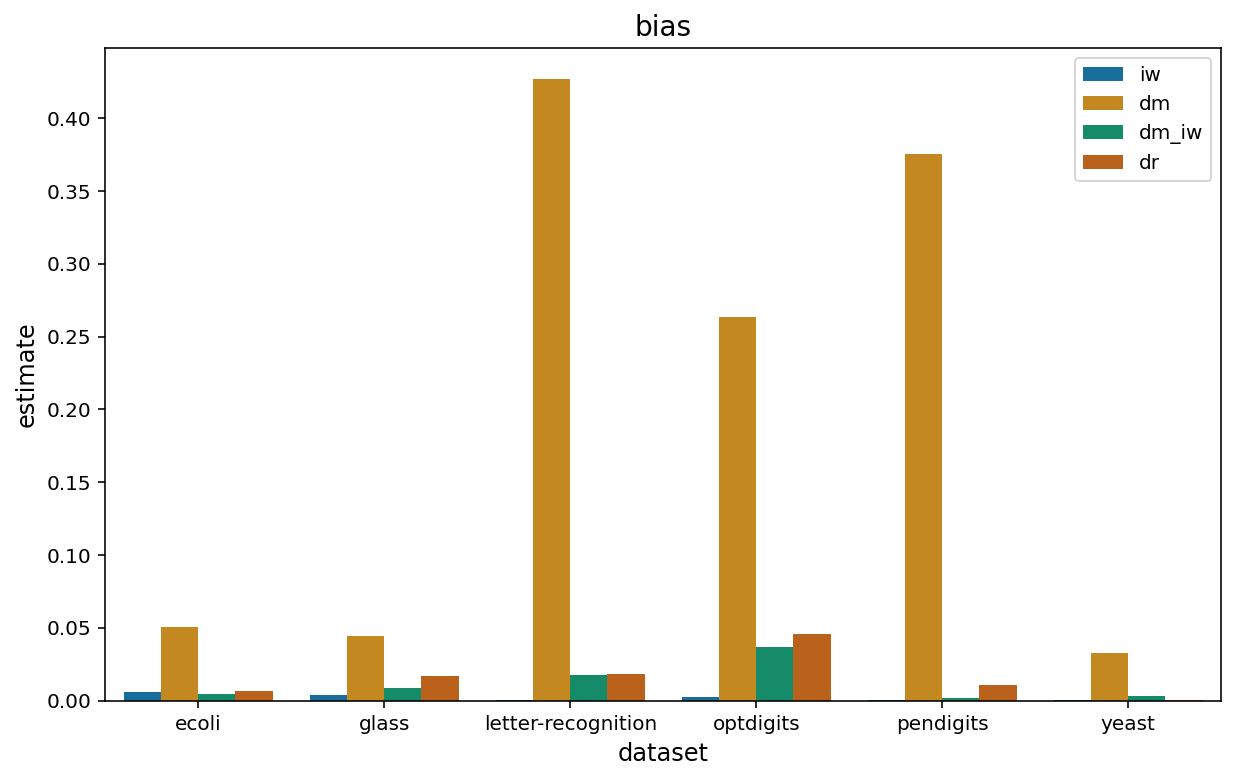

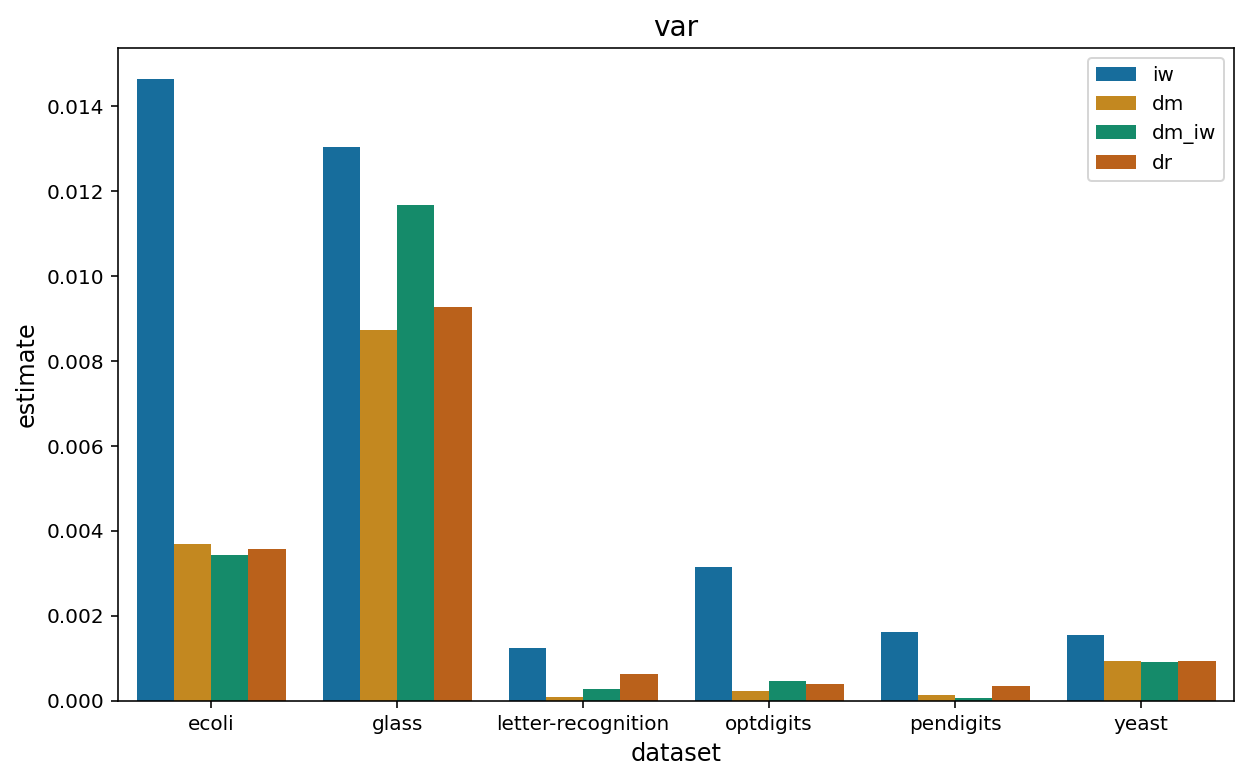

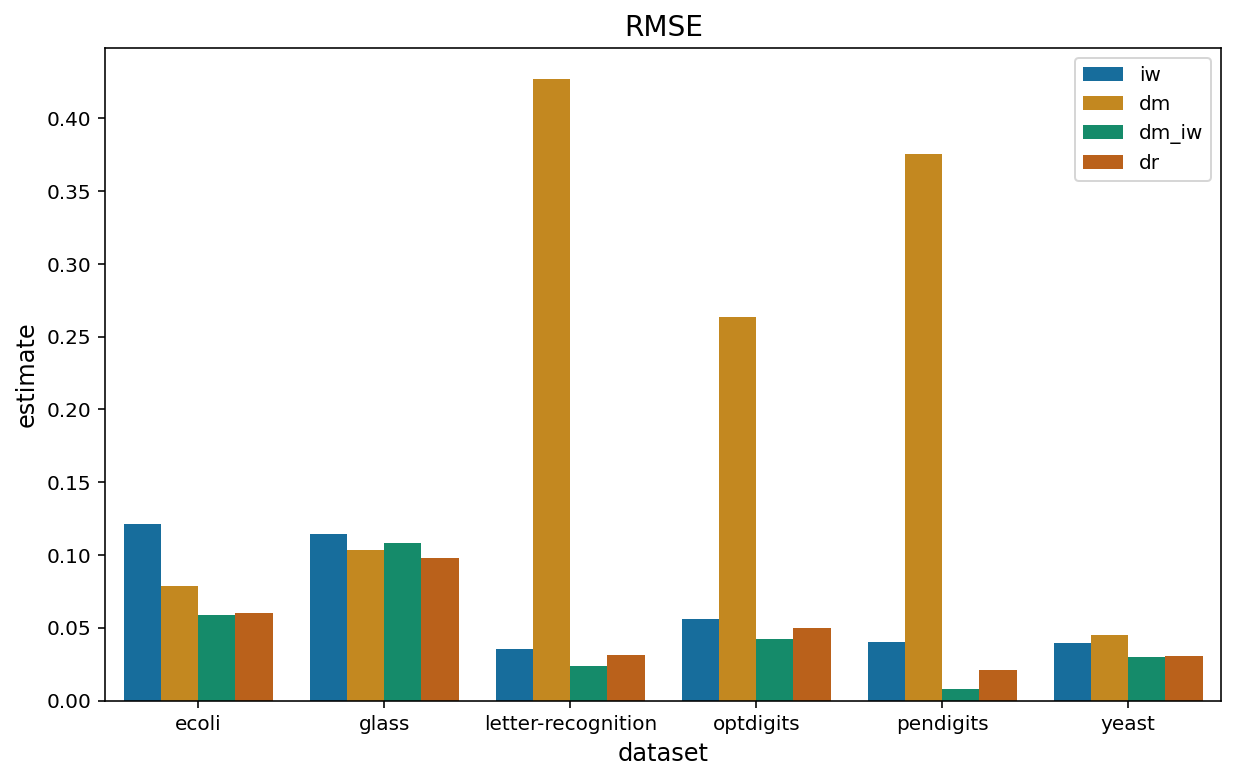

In [48]:
stats = ["mean", "bias", "var", "RMSE"]
for stat in stats:
    iw = []
    dm = []
    dm_iw = []
    dr = []
    for data in datasets:
        iw.append(abs(frames[data][stat][0]))
        dm.append(abs(frames[data][stat][1]))
        dm_iw.append(abs(frames[data][stat][2]))
        dr.append(abs(frames[data][stat][3]))
    df = pd.DataFrame(
        np.c_[iw, dm, dm_iw, dr], index=datasets, columns=["iw", "dm", "dm_iw", "dr"]
    )
    df = (
        df.reset_index()
        .rename({"index": "dataset"}, axis=1)
        .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
    )
    fig, ax = plt.subplots(figsize=XY_MED)
    sns.barplot(data=df, x="dataset", y="estimate", hue="estimator", ax=ax)
    ax.legend()
    ax.set_title(stat)
    ax.tick_params(axis="x", labelrotation=0)